In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import string
from string import digits
import re
import tensorflow as tf
keras = tf.keras
from keras import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout, Input, Concatenate, TimeDistributed
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import random


2023-10-25 09:50:24.173973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 09:50:24.197916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 09:50:24.551320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open('hin.txt','r') as f:
  data = f.read()


## Q1) Preprocessing

In [3]:
uncleaned_data_list = data.split('\n')
uncleaned_data_list.pop()
len(uncleaned_data_list)


2979

In [4]:
english_word = []
hindi_word = []
cleaned_data_list = []

for word in uncleaned_data_list:
  split = word.split('\t')
  english_word.append(split[0])
  hindi_word.append(split[1])

language_data = pd.DataFrame(columns=['English','Hindi'])
language_data['English'] = english_word
language_data['Hindi'] = hindi_word
language_data.to_csv('language_data.csv', index=False)


In [5]:
language_data.head()


,English,Hindi
0,Wow!,वाह!
1,Duck!,झुको!
2,Duck!,बतख़!
3,Help!,बचाओ!
4,Jump.,उछलो.


In [6]:
english_text = language_data['English'].values
hindi_text = language_data['Hindi'].values
len(english_text), len(hindi_text)


(2979, 2979)

In [7]:
english_text_ = [x.lower() for x in english_text]
hindi_text_ = [x.lower() for x in hindi_text]

english_text_ = [re.sub("'",'',x) for x in english_text_]
hindi_text_ = [re.sub("'",'',x) for x in hindi_text_]

def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

english_text_ = remove_punc(english_text_)
hindi_text_ = remove_punc(hindi_text_)

remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))

english_text_ = removed_digits_text
hindi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in hindi_text_]
hindi_text_ = [re.sub("[\u200d]","",x) for x in hindi_text_]

english_text_ = [x.strip() for x in english_text_]
hindi_text_ = [x.strip() for x in hindi_text_]


In [8]:
hindi_text_ = ["start " + x + " end" for x in hindi_text_]
hindi_text_[0], english_text_[0]


('start वाह end', 'wow')

In [9]:
X = english_text_
Y = hindi_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)


In [10]:
def max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

max_length_english = max_length(X_train)
max_length_hindi = max_length(y_train)
max_length_english_test = max_length(X_test)
max_length_hindi_test = max_length(y_test)
max_length_hindi, max_length_english


(27, 22)

In [11]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

hindiTokenizer = Tokenizer()
hindiTokenizer.fit_on_texts(y_train)
Hword2index = hindiTokenizer.word_index
vocab_size_target = len(Hword2index) + 1

y_train = hindiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_hindi, padding='post')
y_test = hindiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_hindi, padding='post')

vocab_size_source, vocab_size_target


(2270, 2890)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


## Q2) Transformer

In [13]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(
            name="W_a",
            shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
            initializer="uniform",
            trainable=True,
        )
        self.U_a = self.add_weight(
            name="U_a",
            shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
            initializer="uniform",
            trainable=True,
        )
        self.V_a = self.add_weight(
            name="V_a",
            shape=tf.TensorShape((input_shape[0][2], 1)),
            initializer="uniform",
            trainable=True,
        )

        super(AttentionLayer, self).build(
            input_shape
        )  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(
                    f"States must be an iterable. Got {states} of type {type(states)}"
                )

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(
                K.dot(inputs, self.U_a), 1
            )  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """Step function for computing ci using ei"""

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(
                    f"States must be an iterable. Got {states} of type {type(states)}"
                )

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(
            encoder_out_seq, axis=2
        )  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """Outputs produced by the layer"""
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1])),
        ]


In [14]:
from keras import backend as K

K.clear_session()
latent_dim = 500

encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = AttentionLayer()
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


2023-10-25 09:50:25.266962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 09:50:25.281321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 09:50:25.281428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 22, 500)      1135000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 22, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

2023-10-25 09:50:26.199443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:50:26.199995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:50:26.200624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
history = model.fit(
    [X_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=50,
    batch_size=512,
    validation_data=(
        [X_test, y_test[:, :-1]],
        y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:, 1:],
    ),
)


Epoch 1/50


2023-10-25 09:50:26.532891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:50:26.533932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:50:26.534609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - ETA: 0s - loss: 6.1513 - accuracy: 0.5662

2023-10-25 09:50:31.514140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:50:31.515563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:50:31.516978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 6s 352ms/step - loss: 6.1513 - accuracy: 0.5662 - val_loss: 2.3802 - val_accuracy: 0.7108
Epoch 2/50
6/6 [==============================] - 1s 220ms/step - loss: 2.2166 - accuracy: 0.7006 - val_loss: 1.9322 - val_accuracy: 0.7108
Epoch 3/50
6/6 [==============================] - 1s 219ms/step - loss: 2.0242 - accuracy: 0.7042 - val_loss: 1.9163 - val_accuracy: 0.7144
Epoch 4/50
6/6 [==============================] - 1s 219ms/step - loss: 2.0015 - accuracy: 0.7059 - val_loss: 1.8720 - val_accuracy: 0.7158
Epoch 5/50
6/6 [==============================] - 1s 215ms/step - loss: 1.9711 - accuracy: 0.7039 - val_loss: 1.8396 - val_accuracy: 0.7164
Epoch 6/50
6/6 [==============================] - 1s 220ms/step - loss: 1.9377 - accuracy: 0.7052 - val_loss: 1.8268 - val_accuracy: 0.7158
Epoch 7/50
6/6 [==============================] - 1s 221ms/step - loss: 1.9273 - accuracy: 0.7062 - val_loss: 1.8332 - val_accuracy: 0.7150
Epoch 8/50
6/6 [===============

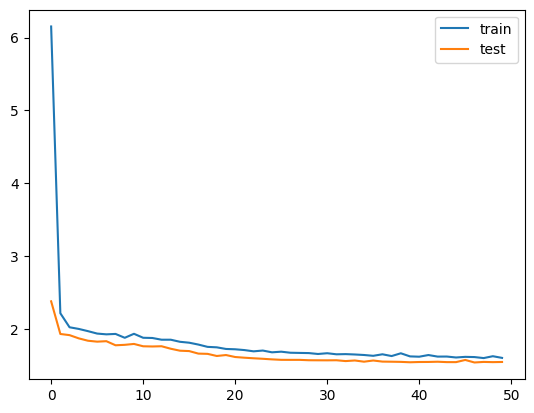

In [17]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [18]:
latent_dim=500

encoder_inputs = model.input[0]
encoder_outputs, state_h, state_c = model.layers[6].output

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(22,latent_dim))

decoder_inputs = model.layers[3].output

dec_emb_layer = model.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)

decoder_lstm = model.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_layer = model.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

decoder_dense = model.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


2023-10-25 09:51:36.533329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:51:36.533939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:51:36.534509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
Eindex2word = englishTokenizer.index_word
Hindex2word = hindiTokenizer.index_word


In [20]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = Hword2index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
            break
        else:
            sampled_token = Hindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token

        if sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence


In [21]:
def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if (i != 0 and i != Hword2index["start"]) and i != Hword2index["end"]:
            newString = newString + Hindex2word[i] + " "
    return newString


def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if i != 0:
            newString = newString + Eindex2word[i] + " "
    return newString


In [22]:
for i in range(10):
    print("Review:", seq2text(X_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print(X_test[i].shape)
    print("Predicted summary:", decode_sequence(X_test[i].reshape(1, 22)))
    print("\n")


2023-10-25 09:51:36.731767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:51:36.732745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:51:36.733313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Review: i am doing business on a large 
Original summary: मैं बड़े पर व्यापार कर रहा हूँ। 
(22,)


2023-10-25 09:51:36.816755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:51:36.817403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:51:36.817959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 11ms/step


2023-10-25 09:51:37.122842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 09:51:37.123485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 09:51:37.124129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 11ms/step
Predicted summary:  वह एक में में


Review: where do you live 
Original summary: तू कहाँ रहती है 
(22,)
1/1 [==============================] - 0s 11ms/step
Predicted summary:  क्या क्या


Review: what is happiness 
Original summary: क्या होता है 
(22,)
1/1 [==============================] - 0s 11ms/step
Predicted summary:  क्या क्या


Review: it is to have good of english nowadays 
Original summary: आजकल अंग्रेज़ी अच्छे से बोलना जानना बहुत ज़रूरी है। 
(22,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  तुम एक में


Review: stand still and keep 
Original summary: शांति से खड़े 
(22,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  क्या क्या


Review: business is so these days 
Original summary: कारोबार में आजकल पड़ गई है। 
(22,)
1/1 [==============================] - 0s 11ms/step
Predicted summary:  क्या क्या


Review: both of my sisters are married 
Original summary: मेरी दोनो शादीशुदा

## Q3) Pretrained transformer

In [23]:
import transformers


In [24]:
MODEL_CHECKPOINT = "t5-small"


In [25]:
# https://huggingface.co/docs/transformers/tasks/translation

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq

model_name = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

train_encodings = tokenizer(list(language_data["English"]), text_target=list(language_data["Hindi"]), truncation=True, padding=True, max_length=200)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name, return_tensors="tf")


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [26]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result


In [27]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)


In [28]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [29]:
tf_train_set = model.prepare_tf_dataset(
    train_encodings,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [ ]:
model.compile(optimizer=optimizer)


In [ ]:
model.fit(x=tf_train_set, epochs=3)
